# Problem Set 2: Classification
Total: 85 points (35 (Q1) + 20 (Q2) + 30 (Q3))

To run and solve this assignment, one must have a working iPython Notebook installation. The
easiest way to set it up  is to install use Google Colab: https://colab.research.google.com/

If you are new to Python or its scientific library, Numpy, there are some nice tutorials here: https://www.learnpython.org and http://scipy-lectures.org.

If a certain output is given for some cells, that means that you are expected to get similar results in order to receive full points (small deviations are fine). For some parts we have already written the code for you. You should read it closely and understand what it does.


### Submission Guideline
You need to submit ONLY the jupyter notebook in gradescope as a PDF. For written questions, you may generate images and display them in the notebook by selecting a “Text” block, and importing an image.


For an equations to png tool, you may use: https://latexeditor.lagrida.com/

Assignment are graded on completion. You will be asked whether you attempted the question or not. Solutions are released post the final deadline (late submission). Please try to solve the question yourself first and write down your own solution and comments for your code. You may check our solution if you are stuck, but do not copy it directly. Your attempted solution should be written by you. Copy pasted solutions will result in zero points. It is extremely important that you complete all assignments (both the programming and written questions), as they will prepare you for quizzes and the exams.



### 1. Logistic Regression

In this part of the exercise, you will build a logistic regression model to predict whether a student
gets admitted into a university.

Suppose that you are the administrator of a university department and you want to determine
each applicant’s chance of admission based on their results on two exams. You have historical
data from previous applicants in *ex2data1.txt* that you can use as a training set for logistic regression. For each
training example, you have the applicant’s scores on two exams and the admissions decision.

Your task is to build a classification model that estimates an applicant’s probability of admission based on the scores from those two exams. This outline and code framework will guide you through the exercise.


**1.1 Visualizing the data**

Before starting to implement any learning algorithm, it is always good to visualize the data if possible. This first part of the code will load the data and display it on a 2-dimensional plot by calling the function plotData. The axes are the two exam scores, and the positive and negative examples are shown with different markers.

In [2]:
################################################################################
# Try to fit your code and comments into 80 charecters because
# - it is guaranteed to look as intened on any screen size
# - it encourages you to write "flater" logic that is easier to reason about
# - it encourages you to decompose logic into comprehansible blocks.
#
# Try to avoid reassinging/mutating variables because when you encounter an
# unexplainable error (and you will) it is easier to have the whole history
# of values to reason about.

In [3]:
# it is good to isolate logical parts to avoid variables leaking into the
# global scope and messing up your logic later in weird ways
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
print('Tested with:')
print('Python', sys.version)
print({x.__name__: x.__version__ for x in [np, matplotlib]})

def read_classification_csv_data(fn, add_ones=False):
    # read comma separated data
    data = np.loadtxt(fn, delimiter=',')
    X_, y_ = data[:, :-1], data[:, -1, None]  # a fast way to keep last dim

    # printing statistics of data before working with it might have saved
    # hundreds hours of of my time, do not repeat my errors :)
    print(X_.shape, X_.min(), X_.max(), X_.dtype)
    print(y_.shape, y_.min(), y_.max(), y_.dtype)
    # aha, y is float! this is not what we expected
    # what might go wrong with further y == 0 checks?
    # A: floating point equality comparison, that's what!

    # insert the column of 1's into the "X" matrix (for bias)
    X = np.insert(X_, X_.shape[1], 1, axis=1) if add_ones else X_
    y = y_.astype(np.int32)
    return X, y

X_data, y_data = read_classification_csv_data('ex2data1.txt', add_ones=True)
print(X_data.shape, X_data.min(), X_data.max(), X_data.dtype)
print(y_data.shape, y_data.min(), y_data.max(), y_data.dtype)

Tested with:
Python 3.10.16 (main, Dec  3 2024, 17:27:57) [Clang 16.0.0 (clang-1600.0.26.4)]
{'numpy': '2.1.3', 'matplotlib': '3.10.0'}
(100, 2) 30.05882244669796 99.82785779692128 float64
(100, 1) 0.0 1.0 float64
(100, 3) 1.0 99.82785779692128 float64
(100, 1) 0 1 int32


In [5]:
X_data

array([[34.62365962, 78.02469282,  1.        ],
       [30.28671077, 43.89499752,  1.        ],
       [35.84740877, 72.90219803,  1.        ],
       [60.18259939, 86.3085521 ,  1.        ],
       [79.03273605, 75.34437644,  1.        ],
       [45.08327748, 56.31637178,  1.        ],
       [61.10666454, 96.51142588,  1.        ],
       [75.02474557, 46.55401354,  1.        ],
       [76.0987867 , 87.42056972,  1.        ],
       [84.43281996, 43.53339331,  1.        ],
       [95.86155507, 38.22527806,  1.        ],
       [75.01365839, 30.60326323,  1.        ],
       [82.30705337, 76.4819633 ,  1.        ],
       [69.36458876, 97.71869196,  1.        ],
       [39.53833914, 76.03681085,  1.        ],
       [53.97105215, 89.20735014,  1.        ],
       [69.07014406, 52.74046973,  1.        ],
       [67.94685548, 46.67857411,  1.        ],
       [70.66150955, 92.92713789,  1.        ],
       [76.97878373, 47.57596365,  1.        ],
       [67.37202755, 42.83843832,  1.   

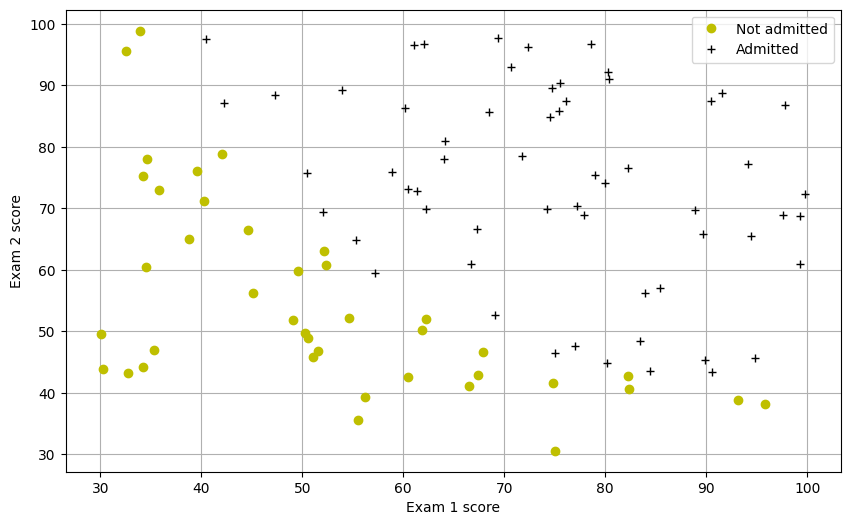

In [7]:
# how does the *X[y.ravel()==1, :2].T trick work?
# https://docs.python.org/3/tutorial/controlflow.html#unpacking-argument-lists

def plot_data(X, y, labels, markers, xlabel, ylabel, figsize=(10, 6), ax=None):
    if figsize is not None:
        plt.figure(figsize=figsize)

    ax = ax or plt.gca()
    for label_id, (label, marker) in enumerate(zip(labels, markers)):
        ax.plot(*X[y.ravel()==label_id, :2].T, marker, label=label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.legend()
    ax.grid(True)

student_plotting_spec = {
    'X': X_data,
    'y': y_data,
    'xlabel': 'Exam 1 score',
    'ylabel': 'Exam 2 score',
    'labels': ['Not admitted', 'Admitted'],
    'markers': ['yo', 'k+'],
    'figsize': (10, 6)
}

plot_data(**student_plotting_spec)
plt.show()

**1.2 [5pts] Sigmoid function**

Before you start with the actual cost function, recall that the logistic regression hypothesis is defined as:

$h_\theta(x) = g(\theta^Tx)$

where function g is the sigmoid function. The sigmoid function is defined as:

$g(z) = \dfrac{1}{1+e^{-z}}$

Your first step is to implement/find a sigmoid function so it can be called by the rest of your program. Your code should also work with vectors and matrices. For a matrix, your function should perform the sigmoid function on every element.

When you are finished, (a) plot the sigmoid function, and (b) test the function with a scalar, a vector, and a matrix. For scalar large positive values of x, the sigmoid should be close to 1, while for scalar large negative values, the sigmoid should be close to 0. Evaluating sigmoid(0) should give you exactly 0.5.

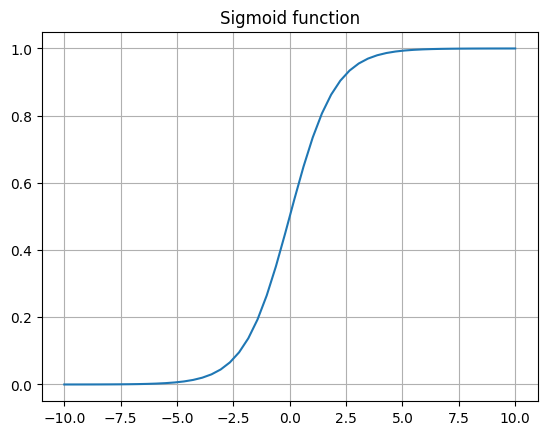

(50,) (49,)


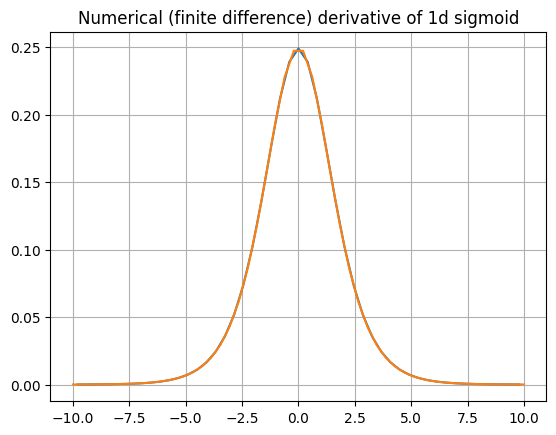

In [8]:
# check out scipy.special for great variaty of vectorized functions
# remember that sigmoid is the inverse of logit function
# maybe worth checking out scipy.special.logit first

from scipy.special import expit

# logit is the inverse function of sigmoid function. The input range of logit function is 0 ~ 1 and it returns the x values from sigmoid function.s
def sigmoid(z):
    return expit(z)

def check_that_sigmoid_f(f):
    # don't use np.arange with float step because it works as
    # val_{i+1} = val_i + step while val_i < end
    # what might do wrong with float precision?
    x_test = np.linspace(-10, 10, 50)
    sigm_test = f(x_test)
    plt.plot(x_test, sigm_test)
    plt.title("Sigmoid function")
    plt.grid(True)
    plt.show()

    # why should analytical_diff almost== finite_diff for sigmoid?
    analytical_diff = sigm_test*(1-sigm_test)
    finite_step = x_test[1]-x_test[0]
    finite_diff = np.diff(sigm_test) / finite_step
    print(x_test.shape, finite_diff.shape)
    plt.plot(x_test[:-1]+finite_step/2, finite_diff)
    plt.plot(x_test, analytical_diff)
    plt.title("Numerical (finite difference) derivative of 1d sigmoid")
    plt.grid(True)
    plt.show()


check_that_sigmoid_f(sigmoid)

**1.3 [15pts] Cost function and gradient**

Now you will implement the cost function and gradient for logistic regression. Complete the code
in the functions *hypothesis_function* and *binary_logistic_loss* below to return the value of the hypothesis function and the cost, respectively. Recall that the cost function in logistic regression is

$j(\theta) \ = \ \frac{1}{m} \ \sum_{i=1}^{m} \ [ \ -y^{(i)} log(h_\theta(x^{(i)})) \ - \ (1 - y^{(i)})log(1-h_\theta(x^{(i)})) \ ]$

and the gradient of the cost is a vector of the same length as $\theta$ where the $j^{th}$ element (for $j = 0, 1,...,n$) is defined as follows:

$\frac{\partial J(\theta)}{\partial \theta_{j}} \ = \ \frac{1}{m} \ \sum_{i=1}^{m} \ (h_\theta(x^{(i)})-y^{(i)}) x_j^{(i)}$

where $m$ is the number of points and $n$ is the number of features. Note that while this gradient looks identical to the linear regression gradient, the formula is
actually different because linear and logistic regression have different definitions of $h_\theta(x)$.

What is the value of loss function for $\theta = \bar 0$ regardless of input? Make sure your code also outputs this value.

In [13]:
def hypothesis_function(x, theta): # Hypothesis function of logistic regression is the sigmoid function
    pred = x @ theta
    return sigmoid(pred)

U = X_data
test_thata = np.zeros((U.shape[1], 1))
test_thata = test_thata.reshape((-1,1))
print(U)
print()
print(test_thata)
result = hypothesis_function(U, test_thata)

print(result)
print(result.shape)
print()
print(y_data.shape)


[[34.62365962 78.02469282  1.        ]
 [30.28671077 43.89499752  1.        ]
 [35.84740877 72.90219803  1.        ]
 [60.18259939 86.3085521   1.        ]
 [79.03273605 75.34437644  1.        ]
 [45.08327748 56.31637178  1.        ]
 [61.10666454 96.51142588  1.        ]
 [75.02474557 46.55401354  1.        ]
 [76.0987867  87.42056972  1.        ]
 [84.43281996 43.53339331  1.        ]
 [95.86155507 38.22527806  1.        ]
 [75.01365839 30.60326323  1.        ]
 [82.30705337 76.4819633   1.        ]
 [69.36458876 97.71869196  1.        ]
 [39.53833914 76.03681085  1.        ]
 [53.97105215 89.20735014  1.        ]
 [69.07014406 52.74046973  1.        ]
 [67.94685548 46.67857411  1.        ]
 [70.66150955 92.92713789  1.        ]
 [76.97878373 47.57596365  1.        ]
 [67.37202755 42.83843832  1.        ]
 [89.67677575 65.79936593  1.        ]
 [50.53478829 48.85581153  1.        ]
 [34.21206098 44.2095286   1.        ]
 [77.92409145 68.97235999  1.        ]
 [62.27101367 69.95445795

In [16]:
# we are trying to fit a function that would return a
# "probability of "

# hypothesis_function describes parametric family of functions that we are
# going to pick our "best fitting function" from. It is parameterized by
# real-valued vector theta, i.e. we are going to pick
#    h_best = argmin_{h \in H} logistic_loss_h(x, y, h)
# but because there exist a bijection between theta's and h's it is
# eqvivalent to choosing
#    theta_best = argmin_{theta \in H} logistic_loss_theta(x, y, theta)

def hypothesis_function(x, theta): # Hypothesis function of logistic regression is the sigmoid function
    pred = x @ theta
    return sigmoid(pred)
    
# negative log likelihood of observing sequence of integer
# y's given probabilities y_pred's of each Bernoulli trial
# recommentation: convert both variables to float's
# or weird sign stuff might happen like -1*y != -y for uint8
# use np.mean and broadcasting
def binary_logistic_loss(y, y_pred):
    assert y_pred.shape == y.shape
    # or weird sign stuff happens! like -1*y != -y
    y, y_pred = y.astype(np.float64), y_pred.astype(np.float64)
    # When y_pred = 0, log(0) = -inf,
    # we could add a small constant to avoid this case
    CONSTANT = 0.000001
    y_pred = np.clip(y_pred, 0+CONSTANT, 1-CONSTANT)

    #TODO: Calculate the log likelihoods
    mle_loss = -1 * np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
    return mle_loss


def logistic_loss_theta_grad(x, y, h, theta):
    """
    Arguments (np arrays of shape):

        x : [m, n] ground truth data
        y : [m, 1] ground truth prediction
        h : [m, n] -> [m, 1] our guess for a prediction function

    """
    # reshape theta: n by 1
    theta = theta.reshape((-1,1))
    y_pred = h(x, theta)
    point_wise_grads = (y_pred - y)*x
    grad = np.mean(point_wise_grads, axis=0)[:, None] # This is the gradient descent for logistic regression
    assert grad.shape == theta.shape
    return grad.ravel()


def logistic_loss_theta(x, y, h, theta):
    # reshape theta: n by 1
    theta = theta.reshape((-1,1))
    return binary_logistic_loss(y, h(x, theta))

In [17]:
# Check that with theta as zeros, cost is about 0.693:
theta_init = np.zeros((X_data.shape[1], 1))
print(logistic_loss_theta(X_data, y_data, hypothesis_function, theta_init))
print(logistic_loss_theta_grad(X_data, y_data, hypothesis_function, theta_init))

0.6931471805599453
[-12.00921659 -11.26284221  -0.1       ]


**1.4 Learning parameters using *scipy.optimize***

In the previous assignment, you found the optimal parameters of a linear regression model by
implementing gradient descent. You wrote a cost function and calculated its gradient, then took
a gradient descent step accordingly. This time, instead of taking gradient descent steps, you will
use a scipy.optimize built-in function called *scipy.optimize.minimize*. In this case, we will use
the *[conjugate gradient algorithm](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-cg.html)*.

The final $\theta$ value will then be used to plot the
decision boundary on the training data, as seen in the figure below.

In [18]:
import scipy.optimize
from functools import partial

In [23]:
def optimize(theta_init, loss, loss_grad, max_iter=10000, print_every=1000, optimizer_fn=None, show=False):
    theta = theta_init.copy()
    opt_args = {'x0': theta_init, 'fun': loss, 'jac': loss_grad, 'options': {'maxiter': max_iter}}

    loss_curve = []
    def scipy_callback(theta):
        f_value = loss(theta)
        loss_curve.append(f_value)

    if optimizer_fn is None:
        optimizer_fn = partial(scipy.optimize.minimize, method='CG', callback=scipy_callback)

    opt_result = optimizer_fn(**opt_args)

    if show:
        plt.plot(loss_curve)
        plt.show()

    return opt_result['x'].reshape((-1, 1)), opt_result['fun']

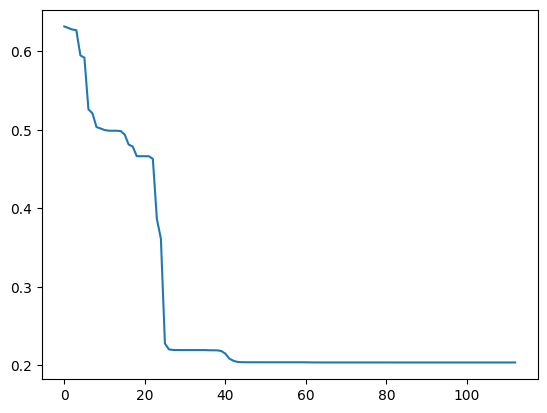

0.20349770208999224


In [24]:
theta_init = np.zeros((3, 1))
loss = partial(logistic_loss_theta, X_data, y_data, hypothesis_function)
loss_grad = partial(logistic_loss_theta_grad, X_data, y_data, hypothesis_function)
theta, best_cost = optimize(theta_init.flatten(), loss, loss_grad, show=True)
print(best_cost)

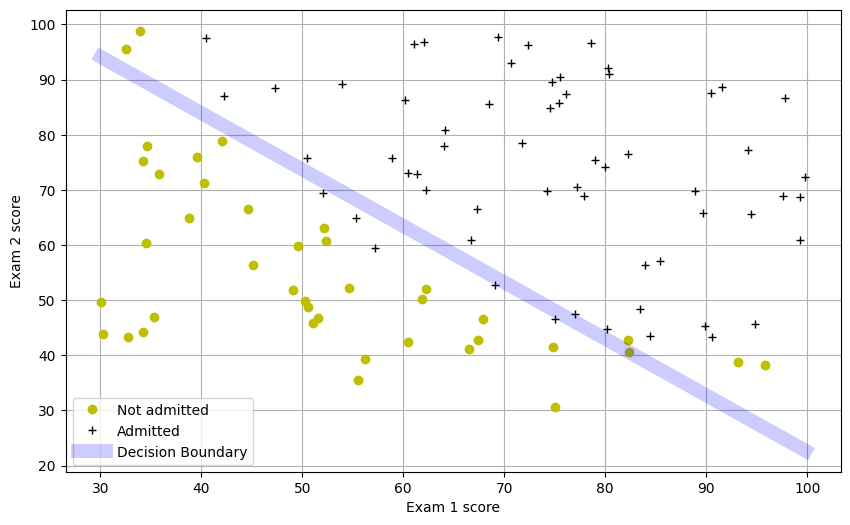

In [25]:
# Plotting the decision boundary: two points, draw a line between
# Decision boundary occurs when h = 0, or when
# theta_0*x1 + theta_1*x2 + theta_2 = 0
# y=mx+b is replaced by x2 = (-1/theta1)(theta2 + theta0*x1)

line_xs = np.array([np.min(X_data[:,0]), np.max(X_data[:,0])])
line_ys = (-1./theta[1])*(theta[2] + theta[0]*line_xs)
plot_data(**student_plotting_spec)
plt.plot(line_xs, line_ys, 'b-', lw=10, alpha=0.2, label='Decision Boundary')
plt.legend()
plt.show()

**1.5 [15pts] Evaluating logistic regression**

After learning the parameters, you can use the model to predict whether a particular student will
be admitted.

(a) [5 pts] Show that for a student with an Exam 1 score of 45 and an Exam 2 score of 85, you should
expect to see an admission probability of 0.776.

Another way to evaluate the quality of the parameters we have found is to see how well the
learned model predicts on our training set.

(b) [10 pts] In this part, your task is to complete the code in
*makePrediction*. The predict function will produce “1” or “0” predictions given a dataset and a learned
parameter vector $\theta$. After you have completed the code, the script below will proceed to report the
training accuracy of your classifier by computing the percentage of examples it got correct. You
should also see a Training Accuracy of 89.0.

In [26]:
# For a student with an Exam 1 score of 45 and an Exam 2 score of 85,
# you should expect to see an admission probability of 0.776.
check_data = np.array([[45., 85., 1]])
print(check_data.shape)
print(hypothesis_function(check_data, theta))

(1, 3)
[[0.77627549]]


In [36]:
# use hypothesis function and broadcast compare operator
def predict(x, theta):
    pred = hypothesis_function(x, theta)
    prediction = (pred >= 0.5).astype(int)
    return  prediction
    

def accuracy(x, y, theta):
    pred = predict(x, theta) 
    accuracy = np.mean(pred == y) # Accuracy is the mean of the 0 and 1 values
    return accuracy

print(accuracy(X_data, y_data, theta))

0.89


### 2. Regularized logistic regression

In this part of the exercise, you will implement regularized logistic regression to predict whether microchips from a fabrication plant pass quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly. Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips in *ex2data2.txt*, from which you can build a logistic regression model.

**2.1 Visualizing the data**

Similar to the previous parts of this exercise, plotData is used to generate the figure below,
where the axes are the two test scores, and the positive (y = 1, accepted) and negative (y = 0,
rejected) examples are shown with different markers.

The figure below shows that our dataset cannot be separated into positive and negative examples by a
straight line. Therefore, a straightforward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.


In [ ]:
X_data_, y_data = read_classification_csv_data('ex2data2.txt')
X_data = X_data_ - X_data_.mean(axis=0)[None, :]
print(X_data.shape, X_data.min(), X_data.max(), X_data.dtype)
print(y_data.shape, y_data.min(), y_data.max(), y_data.dtype)

(118, 2) -0.83007 1.1089 float64
(118, 1) 0.0 1.0 float64
(118, 2) -0.9528415593220338 1.0161210915254237 float64
(118, 1) 0 1 int32


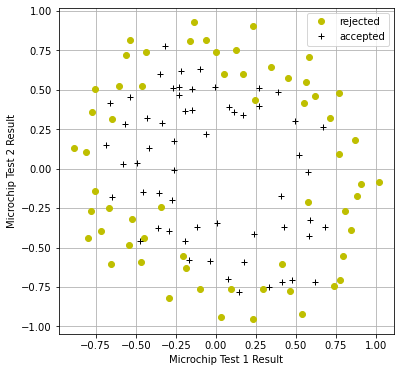

In [ ]:
chip_plotting_spec = {
    'X': X_data,
    'y': y_data,
    'xlabel': 'Microchip Test 1 Result',
    'ylabel': 'Microchip Test 2 Result',
    'labels': ['rejected', 'accepted'],
    'markers': ['yo', 'k+'],
    'figsize': (6, 6)
}

plot_data(**chip_plotting_spec)
plt.show()

**2.2 Nonlinear feature mapping**

One way to fit the data better is to create more features from each data point. In *mapFeature* below, we will map the features into all polynomial terms of $x_1$ and $x_2$ up to the
sixth power as follows:

\begin{equation}
mapFeature(x) \ = \
\begin{bmatrix}
    1 \\
    x_1 \\
    x_2 \\
    x_1^2 \\
    x_1x_2 \\
    x_2^2 \\
    x_1^3 \\
    \vdots \\
    x_1x_2^5 \\
    x_2^6 \\
\end{bmatrix}
\end{equation}

As a result of this mapping, our vector of two features (the scores
on two QA tests) has been transformed into a 28-dimensional
vector. A logistic regression classifier trained on this
higher-dimension feature vector will have a more complex
decision boundary and will appear nonlinear when drawn in our
2-dimensional plot.
While the feature mapping allows us to build a more expressive
classifier, it is also more susceptible to overfitting. In the next parts
of the exercise, you will implement regularized logistic regression
to fit the data and also see for yourself how regularization can help combat the overfitting problem.

Either finite dimentional (or even infinite-dimentional, as you would see in the SVM leacture and the corresponding home assingment) feature mappings are usually denoted by $\Phi$ and therefore our hypothesis is now that the Bernoulli probability of chip matfunctioning might be described as

$$ p_i = \sigma(\Phi(x_i)^T \theta)$$

In [ ]:
from itertools import combinations_with_replacement

def polynomial_feature_map(X_data, degree=20, show_me_ur_powers=False):
    assert len(X_data.shape) == 2
    group_size = X_data.shape[1]
    assert group_size == 2
    # hm.. how to get all ordered pairs (c, d) of non-negative ints
    # such that their sum is c + d <= dergee?
    # it is eqvivalent to getting all groups of integers (a, b) such that
    # 0 <= a <= b <= degree and definintg c = a, d = b - a
    # their sum is below degree, both are >= 0
    # then feature_i = (x_0 ^ c) * (x_1 ^ d)
    comb_iterator = combinations_with_replacement(range(degree+1), group_size)
    not_quite_powers = np.array(list(comb_iterator))
    powers_bad_order = not_quite_powers.copy()
    powers_bad_order[:, 1] -= not_quite_powers[:, 0]
    # let's reoder them so that lower power monomials come first
    rising_power_idx = np.argsort(powers_bad_order.sum(axis=1))
    powers = powers_bad_order[rising_power_idx]
    if show_me_ur_powers is True:
        print(powers.T)
        print('total power per monomial', powers.sum(axis=1))
    X_with_powers = np.power(X_data[:, :, None], powers.T[None])
    # tu tu power rangers (with replacement)
    X_poly = np.prod(X_with_powers, axis=1)
    return X_poly

X_pf = polynomial_feature_map(X_data, show_me_ur_powers=True)
print(X_pf.shape)

[[ 0  0  1  0  2  1  0  2  3  1  4  2  1  3  0  5  3  0  2  4  1  0  6  2
   5  4  3  1  4  0  1  2  6  7  3  5  2  3  4  6  8  5  7  0  1  4  7  3
   6  9  8  0  2  1  5  9  3  5  7  8  4 10  6  1  0  2  0  9  1  4  5  2
  10  7  8  6 11  3  7  0  1  9 12  4  6  2  8 11 10  3  5  6 13  1  5  7
   9  8  4 12  2 10  0 11  3  0 12 11 14 10  9  7  6  8 13  4  2  3  1  5
   5  4  9  0 15 14  7  1 10  8  3  2 11  6 12 13  8  3 11  2 14  9 12 13
  10 16  4  0  6  5  1 15  7 12  5  2 13 11  6 15  3 10  7  0  1 16 14  8
   4  9 17  5 12  2  4  8 14 13 16 11  9  6 15  0  1 10  3 18  7 17 15 13
  14 17 19 18 16  2 12  3  1  4  5  0  7  8  6  9 10 11 11 18  3  1 17 10
   4 16 13  5  0 19 15 12  6  9  7 14  2  8 20]
 [ 0  1  0  2  0  1  3  1  0  2  0  2  3  1  4  0  2  5  3  1  4  6  0  4
   1  2  3  5  3  7  6  5  1  0  4  2  6  5  4  2  0  3  1  8  7  5  2  6
   3  0  1  9  7  8  4  1  7  5  3  2  6  0  4  9 10  8 11  2 10  7  6  9
   1  4  3  5  0  8  5 12 11  3  0  8  6 10  4  1  2  9  7  7  0

**2.3 Cost function and gradient**

Now you will implement code to compute the cost function and gradient for regularized logistic
regression. Recall that the regularized cost function in logistic regression is:

$j(\theta) \ = \ [ \ \frac{1}{m} \ \sum_{i=0}^{m-1} \ [ \ -y^{(i)} log(h_\theta(x^{(i)})) \ - \ (1 - y^{(i)})log(1-h_\theta(x^{(i)})) \ ] \ ] \ + \frac{\lambda}{2m} \sum_{j=1}^{n-1} \theta_j^2 $

Note that you should not regularize the parameter $\theta_0$ (Why not? Think about why that would be a bad idea).

The gradient of the cost function is a vector where the j element is defined as follows (you should understand how to obtain this expression):

$\frac{\partial J(\theta)}{\partial \theta_{0}} \ = \ \frac{1}{m} \ \sum_{i=0}^{m-1} \ (h_\theta(x^{(i)})-y^{(i)}) x_j^{(i)} \quad \quad \quad \quad \quad \quad$ for $\quad j=0$

$\frac{\partial J(\theta)}{\partial \theta_{j}} \ = \ (\frac{1}{m} \ \sum_{i=0}^{m-1} \ (h_\theta(x^{(i)})-y^{(i)}) x_j^{(i)}) + \frac{\lambda}{m}\theta_j \quad \quad \quad$ for $\quad j \ge 1$


**2.3.1 [10pts] Implementing regularized logistic regression**

Re-implement computeCost with regularization.

In [ ]:
# Cost function, default lambda (regularization) 0
def logistic_loss_theta_w_reg(x, y, h, theta, lambda_=0.0):
    raise NotImplementedError('Implement it yourself.')

def logistic_loss_theta_w_reg_grad(x, y, h, theta, lambda_=0.0):
    raise NotImplementedError('Implement it yourself.')

Once you are done, you will call your cost function using the initial value of
θ (initialized to all zeros). You should see that the cost is about 0.693.

0.6931471805599454
(231,)


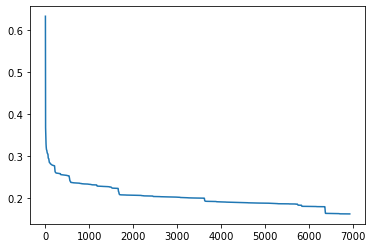

best loss 0.1627064882074352
best acc 0.9322033898305084


In [ ]:
theta_init = np.zeros((X_pf.shape[1], 1))
print(logistic_loss_theta_w_reg(X_pf, y_data, hypothesis_function, theta_init))
print(logistic_loss_theta_w_reg_grad(X_pf, y_data, hypothesis_function, theta_init).shape)

loss = partial(logistic_loss_theta_w_reg, X_pf, y_data, hypothesis_function)
loss_grad = partial(logistic_loss_theta_w_reg_grad, X_pf, y_data, hypothesis_function)
theta, best_cost = optimize(theta_init.flatten(), loss, loss_grad, max_iter=10000, print_every=0, show=True)
print('best loss', best_cost)
print('best acc', accuracy(X_pf, y_data, theta))

**2.4 Plotting the decision boundary**

To help you visualize the model learned by this classifier, we have provided the function
*plotBoundary* which plots the (non-linear) decision boundary that separates the
positive and negative examples.

In [ ]:
def plot_boundary(theta, ax=None):
    """
    Function to plot the decision boundary for arbitrary theta, X, y, lambda value
    Inside of this function is feature mapping, and the minimization routine.
    It works by making a grid of x1 ("xvals") and x2 ("yvals") points,
    And for each, computing whether the hypothesis classifies that point as
    True or False. Then, a contour is drawn with a built-in pyplot function.
    """
    ax = ax or plt.gca()
    x_range = np.linspace(-1,1.5,50)
    y_range = np.linspace(-1,1.5,50)
    xx, yy = np.meshgrid(x_range, y_range)
    X_fake = np.stack([xx, yy]).reshape(2, -1).T
    X_fake_fm = polynomial_feature_map(X_fake)
    y_pred_fake = hypothesis_function(X_fake_fm, theta)
    return ax.contour( x_range, y_range, y_pred_fake.reshape(50, 50).T, [0.5])

**2.4.1 [10pts] Plot Decision Boundaries**

(a) [4 pts] Use *plotBoundary* to obtain four subplots of the decision boundary for the following values of the regularization parameter: $\lambda \ = \ 0, 1, 5, 10$

(b) [2 pts] Comment on which plots are overfitting and which plots are underfitting.

(c) [2 pts] Which is the model with the highest bias? The highest variance?

(d) [2 pts] What is another way to detect overfitting?

(e) [bonus] Considering that later components of theta correspond to higher powers of monomials, plot values of theta and commend on effects of regularization

[(34, 231), (34, 1), (84, 231), (84, 1)]


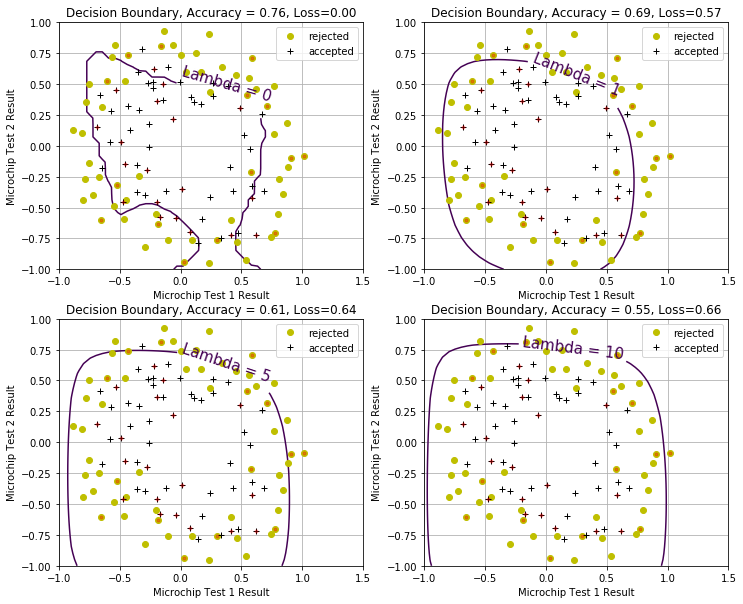

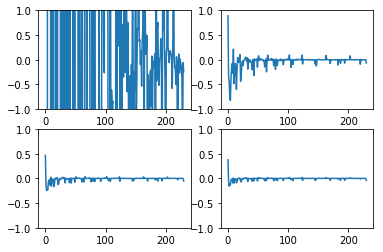

In [ ]:
# (a) Build a figure showing contours for various values of regularization parameter, lambda

np.random.seed(2)
train_idx_mask = np.random.rand(X_pf.shape[0]) < 0.3
X_pf_train, y_train = X_pf[train_idx_mask], y_data[train_idx_mask]
X_pf_test, y_test = X_pf[~train_idx_mask], y_data[~train_idx_mask]
print([x.shape for x in (X_pf_train, y_train, X_pf_test, y_test)])

def silent_optimize_w_lambda(lambda_):
    theta_init = np.zeros((X_pf.shape[1], 1))
    data = (X_pf_train, y_train, hypothesis_function)
    loss = partial(logistic_loss_theta_w_reg, *data, lambda_=lambda_)
    loss_grad = partial(logistic_loss_theta_w_reg_grad, *data, lambda_=lambda_)
    theta, final_loss = optimize(
        theta_init.flatten(), loss, loss_grad, optimizer_fn=None,
        max_iter=1000, print_every=0, show=False
    )
    return theta, final_loss

thetas = []
plt.figure(figsize=(12,10))

# wow, I mutates an object used in the scope of another function (plot_data)
# don't do that! it is really hard to debug later
chip_plotting_spec['figsize'] = None

# you might find following lines useful:
#
#    cnt_fmt = {0.5: 'Lambda = %d' % lambda_}
#    ax.clabel(cnt, inline=1, fontsize=15, fmt=cnt_fmt)
#
# red dots indicate training samples

for id_, lambda_ in enumerate([0, 1, 5, 10]):
    ax = plt.subplot(2, 2, id_+1)
    raise NotImplementedError('Implement it yourself.')

plt.show()

# (e) [bonus] Considering that later components of theta correspond to higher powers
# of monomials, plot values of theta and commend on effects of regularization
ax = None
for th_id, theta in enumerate(thetas):
    ax = plt.subplot(2, 2, th_id+1, sharey=ax)
    raise NotImplementedError('Implement it yourself.')

plt.show()

### 3. Written part

These problems are extremely important preparation for the exam. Submit solutions to each problem by filling the markdown cells below.

**3.1 [10pts]** Maximum likelihood for Logistic Regression

**Showing all steps, derive the LR cost function using maximum likelihood. Assume that the probability of y given x is described by:**

$P(\ y=1 \; \vert \; x \ ; \ \theta \ ) = h_{\theta}(x)$

$P(\ y=0 \; \vert \; x \ ; \ \theta \ ) = 1 - h_{\theta}(x)$

[Put your answer here]

**3.2 [10pts]** Logistic Regression Classification with Label Noise
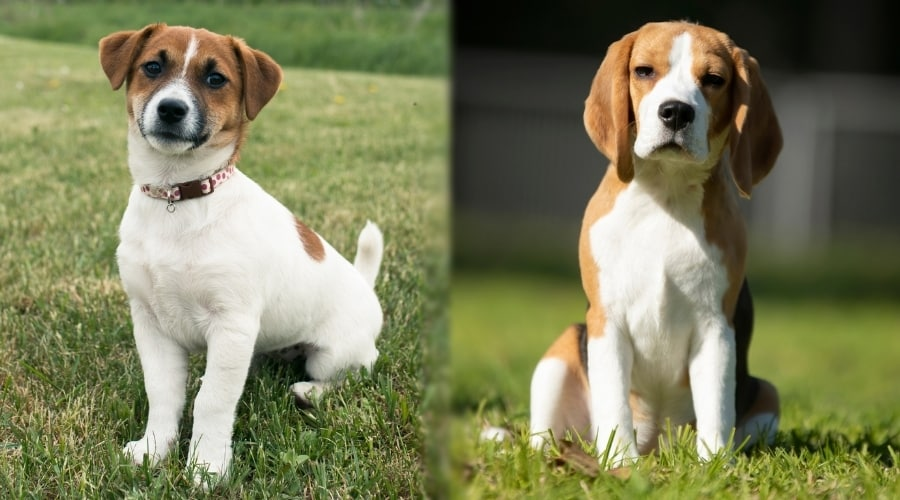

Suppose you are building a classifier for images of dogs to classify them into one of two categories $y \in \{0,1\}$, where 0 is “terrier” and 1 is “beagle.” Each dog image is represented by a feature vector $x$ consisting of image pixels. You decide to use the logistic regression model $p(y = 1 \ \vert \ x) = h_{\theta}(x)=\sigma(\theta^Tx).$ You collected an image dataset and labeled each image with 0 or 1, however, you are not a dog breed expert and you made some mistakes in assigning labels, so they may be different from true labels. Denote your labels as $t^{(i)}$, and the true labels as $y^{(i)}$, your final dataset is D$\ = \{x^{(i)},t^{(i)}\}$.

You then consulted with a friend who is a dog expert and she estimated that you were correct in about $\tau$ fraction of all cases.

**(a) [2pts]** Write down the equation for the posterior probability $p(t = 1 \ \vert \ x)$ of your label being 1 for some point x, in terms of the probability of the true class, $p(y = 1 \ \vert \ x).$

[Put your answer here]

**(b) [8pts]** Derive the modified cost function in terms of $\ \theta, x^{(i)},t^{(i)}$ and $\tau$.

[Put your answer here]

**3.3 [10pts] Cross-entropy loss for multiclass classification**

This problem asks you to derive the cross-entropy loss for a multiclass classification problem using maximum likelihood.
Consider the multiclass classification problem in which each input is assigned to one of $K$ mutually exclusive classes. The binary target variables $y_k$ ∈ {0, 1} have a "one-hot" coding scheme, where the value is 1 for the indicated class and 0 for all others. Assume that we can interpret the network outputs as $h_k(x,\theta) = p(y_k = 1|x)$, or the probability of the kth class.

Show that the maximum likelihood estimate of the parameters $\theta$ can be obtained by minimizing the multiclass *cross-entropy* loss function
<p>
$L(\theta)= - \frac{1}{N}\sum_{i=1}^{N} \sum_{k=1}^{K} y_{ik} \log(h_k(x_i,\theta))$
</p>
<p>
where $N$ is the number of examples $\{x_i,y_i\}$. </p>

[Put your answer here]